In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scripts import m5_common
from tqdm.notebook import tqdm
from typing import Union

import mlflow
import mlflow.sklearn

pd.options.display.max_columns = 50

### Path

In [3]:
path = Path('/kaggle/m5_forecasting/')
assert(path.exists())

In [4]:
h = 28 
tr_last = 1913
fday = datetime(2016, 4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

### Connect to MLflow server

In [5]:
# mlflow server --backend-store-uri mlruns/ --default-artifact-root mlruns/ --host 0.0.0.0 --port 5000
# server in /opt/mlflow_server/start.sh
remote_server_uri = "http://localhost:5000" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)  # or set the MLFLOW_TRACKING_URI in the env

In [6]:
mlflow.tracking.get_tracking_uri()

'http://localhost:5000'

In [7]:
mlflow.set_experiment('M5_Public')

### Ingest Data

In [8]:
%%time

prices, cal = m5_common.prepare_tables(path)

CPU times: user 1.42 s, sys: 191 ms, total: 1.61 s
Wall time: 1.61 s


In [9]:
weather_df = pd.read_csv(path/'weather/weather_2010_2020.csv')
weather_df["date"] = pd.to_datetime(weather_df["Date"])
del weather_df["Date"]
del weather_df["Anomaly"]
weather_df['Value'] = weather_df['Value'].astype('float16')
weather_df.columns = ['temperature',  'date']

In [10]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   temperature  3257 non-null   float16       
 1   date         3257 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float16(1)
memory usage: 31.9 KB


In [11]:
# %%time

# cal = cal.merge(weather_df, on=['date'], copy = False)

In [12]:
event_name_1_map, event_type_1_map = m5_common.replace_cal_cols(cal)

In [13]:
cal[(cal.date > '2012-01-01') & (cal.date < '2012-01-05')]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
338,2012-01-02,11149,1,3,1,2012,d_339,0,0,0,0,1.0,0.0,1.0
339,2012-01-03,11149,5,4,1,2012,d_340,0,0,0,0,1.0,1.0,1.0
340,2012-01-04,11149,6,5,1,2012,d_341,0,0,0,0,1.0,0.0,0.0


In [14]:
uint8_types= ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'month', 'wday', 'weekday', 
              'snap_CA', 'snap_TX', 'snap_WI']
m5_common.convert_uint8(cal, uint8_types)

In [15]:
def get_elapsed(dt, event_name='Christmas', col='event_name_1', event_map=event_name_1_map, before=False):
    dt.sort_values(['date'], ascending=[(not before)], inplace=True)
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    res = []
    event = event_map[event_name]
    for v,d in zip(dt[col].values, dt.date.values):
        if v == event:
            last_date = d
        elapsed = ((d-last_date).astype('timedelta64[D]') / day1)
        res.append(elapsed)
    field_name = f"{'before' if before else 'after'}_{event_name.lower().replace(' ', '_')}"
    dt[field_name] = res
    dt[field_name] = dt[field_name].fillna(0)
    dt[field_name] = dt[field_name].astype('int16')

In [16]:
# ellapsed_fields = ['Christmas', 'Easter', 'Ramadan starts']
# for f in ellapsed_fields:
#     get_elapsed(cal, f, 'event_name_1', event_name_1_map, False)

In [17]:
def add_mean_over_period(dt, period='weekday'):
    df_sales_id_period = dt[['id', 'sales', period]].groupby(['id', period])[['sales']].mean().reset_index()
    df_sales_id_period['sales'] = df_sales_id_period['sales'].astype('float16')
    df_sales_id_period.rename(columns={'sales': f'sales_by_{period}'}, inplace=True)
    return dt.merge(df_sales_id_period, on=['id', period], how='left')

In [18]:
day_of_year = 'Dayofyear'

def prepare_day_of_year(df):
    df[day_of_year] = getattr(df['date'].dt, day_of_year.lower()).astype('uint16')

In [19]:
def add_days_before(dt, day=25, month=12, col_name='before_christmas'):
    diff_list = []
    for d in dt['date']:
        target = datetime(d.year, month, day)
        diff = (target - d.to_pydatetime()).days
        if(diff < 0):
            christmas = datetime(d.year + 1, month, day)
            diff = (christmas - d.to_pydatetime()).days
            if diff < 0:
                print('target', target, d, diff)
        diff_list.append(diff)
    dt[col_name] = diff_list
    dt[col_name] = dt[col_name].astype('uint16')

In [20]:
add_days_before(cal)
# add_days_before(cal, day=31, month=10, col_name='before_halloween')
# add_days_before(cal, day=4, month=7, col_name='before_independence_day')

In [21]:
def event_in_week(event_field='event_name_1', cal_field_name='events_in_week'):
    events_in_week = []
    no_monday_yet = True
    for i, row in cal.iterrows():
        if row['date'].weekday() == 0: # Monday
            no_monday_yet = False
            counter = 0
            for j in range(7):
                data = cal.loc[i + j]
                if data[event_field] > 0:
                    counter += 1
            for j in range(7):
                events_in_week.append(counter)
        if no_monday_yet:
            events_in_week.append(0)
    assert(len(events_in_week) == len(cal))
    cal[cal_field_name] = events_in_week
    cal[cal_field_name] = cal[cal_field_name].astype('uint8')

In [22]:
# event_in_week('event_name_1', 'events1_in_week')
# cal['events1_in_week_before_7'] = cal['events1_in_week'].shift(7, fill_value=0).astype('uint8')
# cal['events1_in_week_after_7'] = cal['events1_in_week'].shift(-7, fill_value=0).astype('uint8')

In [23]:
easter_western = {2011: datetime(2011, 4, 24), 2012: datetime(2012, 4, 8), 2013: datetime(2013, 3, 31)
 , 2014: datetime(2014, 4, 20), 2015: datetime(2015, 4, 5), 2016: datetime(2016, 4, 27), 2017: datetime(2017, 4, 16)}

def add_days_before_special_date(dt, date_dict=easter_western, col_name='before_easter'):
    diff_list = []
    for d in cal['date']:
        year = d.year
        target = date_dict[year]
        diff = (target - d.to_pydatetime()).days
        if(diff < 0):
            target = date_dict[year + 1]
            diff = (target - d.to_pydatetime()).days
        diff_list.append(diff)
    dt[col_name] = diff_list
    dt[col_name] = dt[col_name].astype('uint16')

In [24]:
# add_days_before_special_date(cal)

In [25]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              1969 non-null   datetime64[ns]
 1   wm_yr_wk          1969 non-null   int16         
 2   weekday           1969 non-null   uint8         
 3   wday              1969 non-null   uint8         
 4   month             1969 non-null   uint8         
 5   year              1969 non-null   int16         
 6   d                 1969 non-null   object        
 7   event_name_1      1969 non-null   uint8         
 8   event_type_1      1969 non-null   uint8         
 9   event_name_2      1969 non-null   uint8         
 10  event_type_2      1969 non-null   uint8         
 11  snap_CA           1969 non-null   uint8         
 12  snap_TX           1969 non-null   uint8         
 13  snap_WI           1969 non-null   uint8         
 14  before_christmas  1969 n

In [26]:
cal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas
0,2011-01-29,11101,2,1,1,2011,d_1,0,0,0,0,0,0,0,330
1,2011-01-30,11101,3,2,1,2011,d_2,0,0,0,0,0,0,0,329
2,2011-01-31,11101,1,3,1,2011,d_3,0,0,0,0,0,0,0,328
3,2011-02-01,11101,5,4,2,2011,d_4,0,0,0,0,1,1,0,327
4,2011-02-02,11101,6,5,2,2011,d_5,0,0,0,0,1,0,1,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,6,5,6,2016,d_1965,0,0,0,0,0,1,1,193
1965,2016-06-16,11620,4,6,6,2016,d_1966,0,0,0,0,0,0,0,192
1966,2016-06-17,11620,0,7,6,2016,d_1967,0,0,0,0,0,0,0,191
1967,2016-06-18,11621,2,1,6,2016,d_1968,0,0,0,0,0,0,0,190


In [27]:
state_map = {'CA': 0, 'TX': 1, 'WI': 2}

In [28]:
def process_snap(dt):
    dt['snap'] = ((dt['snap_CA'] == 1) & (dt['state_id'] == state_map['CA']) 
              | (dt['snap_TX'] == 1) & (dt['state_id'] == state_map['TX']) 
              | (dt['snap_WI'] == 1) & (dt['state_id'] == state_map['WI']))
    
    dt['snap'] = dt['snap'].astype('uint8')
    
    for c in ['snap_CA', 'snap_TX', 'snap_WI']:
        del dt[c]

In [29]:
FIRST_DAY = 1 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [30]:
%%time

df = m5_common.create_dt(cal, prices, is_train=True, first_day= FIRST_DAY, tr_last=tr_last, path=path)

CPU times: user 41.9 s, sys: 5.92 s, total: 47.9 s
Wall time: 47.9 s


In [31]:
def replace_cat(dt, field, target_type='uint8'):
    uniques = dt[field].unique()
    uniques.sort()
    mapping = {e: i for i, e in enumerate(uniques)}
    print(mapping)
    dt.replace({field: mapping}, inplace=True)
    dt[field] = dt[field].astype(target_type)

def replace_cats(dt):
    replace_cat(dt, 'wday')
    replace_cat(dt, 'month')
    replace_cat(dt, 'year')
    replace_cat(dt, 'mday')

In [32]:
replace_cats(df)

# replace_cat(df, 'Dayofyear', 'uint16')
# replace_cat(df, 'week')

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11}
{2011: 0, 2012: 1, 2013: 2, 2014: 3, 2015: 4, 2016: 5}
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30}


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 4081 to 46025082
Data columns (total 27 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           int16         
 3   store_id          int16         
 4   cat_id            int16         
 5   state_id          int16         
 6   d                 object        
 7   sales             float16       
 8   date              datetime64[ns]
 9   wm_yr_wk          int16         
 10  weekday           uint8         
 11  wday              uint8         
 12  month             uint8         
 13  year              uint8         
 14  event_name_1      uint8         
 15  event_type_1      uint8         
 16  event_name_2      uint8         
 17  event_type_2      uint8         
 18  snap_CA           uint8         
 19  snap_TX           uint8         
 20  snap_WI           uint8         
 21  bef

In [34]:
# Fraction of zeros
df[df['sales'] == 0.].shape[0] / df.shape[0]

0.6115931671701179

In [35]:
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas,sell_price,Dayofyear,week,mday,lag_price_1
4081,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_1,3.0,2011-01-29,11101,2,0,0,0,0,0,0,0,0,0,0,330,5.269531,29,4,28,NaN
4082,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_2,0.0,2011-01-30,11101,3,1,0,0,0,0,0,0,0,0,0,329,5.269531,30,4,29,5.269531
4083,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_3,0.0,2011-01-31,11101,1,2,0,0,0,0,0,0,0,0,0,328,5.269531,31,5,30,5.269531
4084,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_4,1.0,2011-02-01,11101,5,3,1,0,0,0,0,0,1,1,0,327,5.269531,32,5,0,5.269531
4085,FOODS_1_001_CA_1_evaluation,1536,4,0,2,0,d_5,4.0,2011-02-02,11101,6,4,1,0,0,0,0,0,1,0,1,326,5.269531,33,5,1,5.269531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45956915,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1909,0.0,2016-04-20,11612,6,4,3,5,0,0,0,0,0,0,0,249,1.000000,111,16,19,1.000000
45956916,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1910,0.0,2016-04-21,11612,4,5,3,5,0,0,0,0,0,0,0,248,1.000000,112,16,20,1.000000
45956917,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1911,0.0,2016-04-22,11612,0,6,3,5,0,0,0,0,0,0,0,247,1.000000,113,16,21,1.000000
46025081,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1912,0.0,2016-04-23,11613,2,0,3,5,0,0,0,0,0,0,0,246,1.000000,114,16,22,1.000000


### Feature Engineering

In [36]:
def create_fea(dt, dropna=True):
    
    wins = [7, 28]
    lags = [7, 28]
    
    grouped_sales = dt[["id","sales"]].groupby("id")["sales"]
    
    for win in wins:
        mean_col = f'mean_{win}'
        emean_col = f'e{mean_col}' # exponential mean average
        esmean_col = f'es{mean_col}'
        dt[emean_col] = grouped_sales.transform(lambda x : x.ewm(span=win, adjust=False).mean())
        dt[esmean_col] = grouped_sales.transform(lambda x : x.ewm(alpha=1/win, adjust=False).mean())
        for lag in lags:
            dt[f'emean_{win}_{lag}'] = dt[["id", emean_col]].groupby("id").shift(lag)
            dt[f'esmean_{win}_{lag}'] = dt[["id", esmean_col]].groupby("id").shift(lag)
        del dt[emean_col]
        del dt[esmean_col]
            
    ra = range(1, 8)
    for simple_lag in ra:
        dt[f'lag_{simple_lag}'] = dt[["id","sales"]].groupby("id")["sales"].shift(simple_lag)
    
    if dropna == True:
        dt.dropna(inplace = True)

In [37]:
%%time

create_fea(df)

CPU times: user 1min 52s, sys: 10.4 s, total: 2min 2s
Wall time: 2min 2s


In [38]:
df.dropna(inplace = True)
df.shape

(45174237, 42)

In [39]:
df.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas,sell_price,Dayofyear,week,mday,lag_price_1,emean_7_7,esmean_7_7,emean_7_28,esmean_7_28,emean_28_7,esmean_28_7,emean_28_28,esmean_28_28,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
45956915,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1909,0.0,2016-04-20,11612,6,4,3,5,0,0,0,0,0,0,0,249,1.0,111,16,19,1.0,0.000059,0.002300,0.024963,0.058594,0.017822,0.038788,0.079956,0.083252,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45956916,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1910,0.0,2016-04-21,11612,4,5,3,5,0,0,0,0,0,0,0,248,1.0,112,16,20,1.0,0.000045,0.001972,0.018723,0.050201,0.016602,0.037384,0.074463,0.080261,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45956917,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1911,0.0,2016-04-22,11612,0,6,3,5,0,0,0,0,0,0,0,247,1.0,113,16,21,1.0,0.000033,0.001690,0.014038,0.043030,0.015457,0.036041,0.069336,0.077393,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46025081,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1912,0.0,2016-04-23,11613,2,0,3,5,0,0,0,0,0,0,0,246,1.0,114,16,22,1.0,0.000025,0.001449,0.010529,0.036896,0.014389,0.034760,0.064514,0.074646,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46025082,HOUSEHOLD_2_516_WI_3_evaluation,2047,3,9,1,2,d_1913,0.0,2016-04-24,11613,3,1,3,5,0,0,0,0,0,0,0,245,1.0,115,16,23,1.0,0.000019,0.001242,0.007896,0.031616,0.013397,0.033539,0.060089,0.071960,0.0,0.0,0.0,0.0,0.0,0.0,0.0


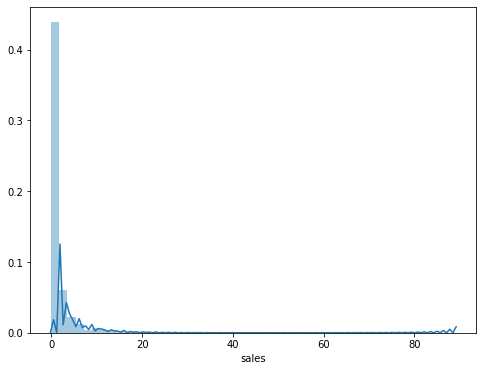

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df['sales'][:200000])

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45174237 entries, 342559 to 46025082
Data columns (total 42 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           int16         
 3   store_id          int16         
 4   cat_id            int16         
 5   state_id          int16         
 6   d                 object        
 7   sales             float16       
 8   date              datetime64[ns]
 9   wm_yr_wk          int16         
 10  weekday           uint8         
 11  wday              uint8         
 12  month             uint8         
 13  year              uint8         
 14  event_name_1      uint8         
 15  event_type_1      uint8         
 16  event_name_2      uint8         
 17  event_type_2      uint8         
 18  snap_CA           uint8         
 19  snap_TX           uint8         
 20  snap_WI           uint8         
 21  b

#### Random feature selection

In [42]:
feature_lags = [f'lag_{i}' for i in range(1, 8)]
feature_pool = ['before_christmas', 'sell_price', 'Dayofyear', 'week', 'lag_price_1', 'emean_7_7', 'esmean_7_7', 'emean_7_28',            
                'esmean_7_28', 'emean_28_7', 'esmean_28_7', 'emean_28_28', 'esmean_28_28'] + feature_lags                  
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id', 
             "event_name_1", "event_name_2", "event_type_1", "event_type_2", 'snap_CA', 'snap_TX', 'snap_WI']

import random

def reduce_features(feature_pool, size):    
    random.shuffle(feature_pool)
    return feature_pool[:size]

selected_features = reduce_features(feature_pool, 15)

selected_features = selected_features + cat_feats + ['id', 'date', 'sales', 'wday', 'month', 'year', 'mday']
selected_features.sort()

print('selected_features', selected_features)

def remove_features(dt, selected_features):
    for col in dt.columns:
        if col not in selected_features:
            del dt[col]

selected_features ['Dayofyear', 'before_christmas', 'cat_id', 'date', 'dept_id', 'emean_28_28', 'emean_28_7', 'emean_7_28', 'esmean_28_28', 'esmean_7_7', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2', 'id', 'item_id', 'lag_1', 'lag_2', 'lag_4', 'lag_5', 'lag_7', 'lag_price_1', 'mday', 'month', 'sales', 'sell_price', 'snap_CA', 'snap_TX', 'snap_WI', 'state_id', 'store_id', 'wday', 'week', 'year']


In [43]:
remove_features(df, selected_features)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45174237 entries, 342559 to 46025082
Data columns (total 34 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           int16         
 3   store_id          int16         
 4   cat_id            int16         
 5   state_id          int16         
 6   sales             float16       
 7   date              datetime64[ns]
 8   wday              uint8         
 9   month             uint8         
 10  year              uint8         
 11  event_name_1      uint8         
 12  event_type_1      uint8         
 13  event_name_2      uint8         
 14  event_type_2      uint8         
 15  snap_CA           uint8         
 16  snap_TX           uint8         
 17  snap_WI           uint8         
 18  before_christmas  uint16        
 19  sell_price        float16       
 20  Dayofyear         uint16        
 21  w

In [ ]:
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

np.random.seed(777)

size_valid_set = 2_000_000
fake_valid_inds = np.random.choice(X_train.index.values, size_valid_set, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)

In [ ]:
X = X_train.loc[train_inds]
y = y_train.loc[train_inds]

X_valid = X_train.loc[fake_valid_inds]
y_valid = y_train.loc[fake_valid_inds]

In [ ]:
del df
gc.collect()

In [ ]:
leave_size = 10
params = {
        'boosting_type': 'gbdt',
        "objective" : "tweedie",
        'tweedie_variance_power': 1.25,
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
#         "lambda_l1" : 0.2,
        "lambda_l2" : 0.1,
        "nthread" : 10,
        "metric": ["rmse"],
        'verbosity': 20,
        'num_leaves': 2**leave_size-1,
        "min_data_in_leaf": 2**(leave_size + 1)-1,
        "n_estimators": 100
}

In [ ]:
class Importance():
    
    def __init__(self, model, eval_metric):
        self.model, self.eval_metric = model, eval_metric
        self.feature_importances = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats, ax=ax)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]
    
    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in [self.model]:
            evals_result = pd.DataFrame()
            for k in model.evals_result_.keys():
                evals_result[k] = model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
#         categorical_feature  plt.title('Training progress')

In [ ]:
def run_pred(m_lgb):
    max_lags = h * 2 + 1
    sub = 0.
    cols = [f"F{i}" for i in range(1,29)]
    te = m5_common.create_dt(cal, prices, False, first_day=FIRST_DAY, path=path)
    replace_cats(te)

    for tdelta in tqdm(range(0, h), total=h):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst, False)
        remove_features(tst, selected_features)
        tst = tst.loc[tst.date == day, train_cols]
        te.loc[te.date == day, "sales"] = m_lgb.predict(tst)

    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
    te_sub["id"] = te_sub["id"].str.replace("evaluation$", "validation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    sub = te_sub

    sub2 = sub.copy()
    sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
    sub = pd.concat([sub, sub2], axis=0, sort=False)
    sub.to_csv("submission.csv",index=False)

In [ ]:
## evaluation metric
## from https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834 and edited to get scores at all levels
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'cat_id',
            'state_id',
            'dept_id',
            'store_id',
            'item_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        group_ids = []
        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            group_ids.append(group_id)
            all_scores.append(lv_scores.sum())

        return group_ids, all_scores

In [ ]:
## public LB rank
def get_lb_rank(score):
    """
    Get rank on public LB as of 2020-05-31 23:59:59
    """
    return (df_lb.Score <= score).sum() + 1

def validation_ranking(mlflow):
    ## new train data
    df_train_full = pd.read_csv(path/"sales_train_evaluation.csv")
    df_train_full.iloc[:, -31:].head()
    
    df_lb = pd.read_csv(path/"m5-forecasting-accuracy-publicleaderboard-rank.csv")
    
    ## reading data
    df_calendar = pd.read_csv(path/"calendar.csv")
    df_prices = pd.read_csv(path/"sell_prices.csv")
    df_sample_submission = pd.read_csv(path/"sample_submission.csv")
    df_sample_submission["order"] = range(df_sample_submission.shape[0])

    df_train = df_train_full.iloc[:, :-28]
    df_valid = df_train_full.iloc[:, -28:]

    evaluator = WRMSSEEvaluator(df_train, df_valid, df_calendar, df_prices)
    
    ## structure of validation data
    preds_valid = df_valid.copy() + np.random.randint(100, size = df_valid.shape)

    ## evaluating submission from public kernel M5 - Three shades of Dark: Darker magic
    preds_valid = pd.read_csv("submission.csv")
    preds_valid = preds_valid[preds_valid.id.str.contains("validation")]
    preds_valid = preds_valid.merge(df_sample_submission[["id", "order"]], on = "id").sort_values("order").drop(["id", "order"], axis = 1).reset_index(drop = True)
    preds_valid.rename(columns = {
        "F1": "d_1914", "F2": "d_1915", "F3": "d_1916", "F4": "d_1917", "F5": "d_1918", "F6": "d_1919", "F7": "d_1920",
        "F8": "d_1921", "F9": "d_1922", "F10": "d_1923", "F11": "d_1924", "F12": "d_1925", "F13": "d_1926", "F14": "d_1927",
        "F15": "d_1928", "F16": "d_1929", "F17": "d_1930", "F18": "d_1931", "F19": "d_1932", "F20": "d_1933", "F21": "d_1934",
        "F22": "d_1935", "F23": "d_1936", "F24": "d_1937", "F25": "d_1938", "F26": "d_1939", "F27": "d_1940", "F28": "d_1941"
    }, inplace = True)

    groups, scores = evaluator.score(preds_valid)

    score_public_lb = np.mean(scores)
    score_public_rank = get_lb_rank(score_public_lb)

    for i in range(len(groups)):
        print(f"Score for group {groups[i]}: {round(scores[i], 5)}")

    print(f"\nPublic LB Score: {round(score_public_lb, 5)}")
    mlflow.log_metric(key="Public LB Score", value=round(score_public_lb, 5))
    mlflow.set_tag(key="Public LB Rank", value=str(score_public_rank))

In [ ]:
%%time

with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_param(key="features", value=str(selected_features))
    m_lgb_regressor = lgb.LGBMRegressor(**params)
    m_lgb_regressor.fit(X=X, y=y, 
              eval_set=[(X, y), (X_valid, y_valid)],
              eval_names=['train sales', 'valid sales'], 
              eval_metric=params['metric'],
              verbose=params['verbosity'],
              early_stopping_rounds=100,
              categorical_feature=cat_feats)
    mlflow.log_metric(key="train_rmse_best", value=m_lgb_regressor.best_score_['train sales']['rmse'])
    mlflow.log_metric(key="valid_rmse_best", value=m_lgb_regressor.best_score_['valid sales']['rmse'])
    mlflow.set_tag(key="importance", value=str({c: f for (c, f )in zip(X_train.columns, m_lgb_regressor.feature_importances_)}))
    run_pred(m_lgb_regressor)
    validation_ranking(mlflow)

In [ ]:
importance = Importance(m_lgb_regressor, 'rmse')
importance.plot_feature_importance(top_n=40)

In [ ]:
importance.plot_metric()

In [ ]:
for iter in [None, 800, 1000, 1200]:
    m_lgb_regressor.booster_.save_model(str(path/f"m5_model_{'best' if iter is None else iter}.lgb"), num_iteration=iter)

In [ ]:
m_lgb = lgb.Booster(model_file=str(path/"m5_model_best.lgb"))
# m_lgb = lgb.Booster(model_file=str(path/"m5_model_1200.lgb"))

In [ ]:
!du -h {path/"m5_model*.lgb"}